In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
import json
import os
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    average_precision_score, precision_recall_curve,
    confusion_matrix, classification_report, f1_score,
    precision_score, recall_score, roc_auc_score
)
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTENC

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

RANDOM_STATE = 42
TEST_SIZE = 0.2
TOL = 1e-6
HIGH_AMOUNT_THRESHOLD = 1_000_000
SUSPICIOUS_SENDER_MIN_TXNS = 3
COST_PER_INVESTIGATION = 50
FRAUD_AVERAGE_LOSS = 1000

print("Libraries imported and configured")

✅ Libraries imported and configured


In [4]:
def load_data(filepath="./data/fraud_detection_data.csv"):
    print("LOADING DATA : \n ")
    
    data = pd.read_csv(filepath)
    
    print(f"📊 Dataset Shape: {data.shape}")
    print(f"\n📋 Columns:\n{data.columns.tolist()}")
    print(f"\n🔍 Data Types:\n{data.dtypes}")
    
    # Display first few rows
    print("\n📝 First 5 rows:")
    display(data.head())
    
    return data

# Load the data
data = load_data()

LOADING DATA


C:\Users\dell\AppData\Local\Temp\ipykernel_10892\3678549090.py:7: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(filepath)


📊 Dataset Shape: (6362620, 11)

📋 Columns:
['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig', 'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud']

🔍 Data Types:
step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud     object
dtype: object

📝 First 5 rows:


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0x
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [5]:
def clean_data(data):
    print("DATA CLEANING \n")
    
    data_clean = data.copy()
    
    # remove transactions with zero balances
    balance_cols = ["oldbalanceOrg", "newbalanceOrig", 
                    "oldbalanceDest", "newbalanceDest", "amount"]
    
    zero_rows = data_clean[
        (data_clean["amount"] == 0) &
        (data_clean["oldbalanceOrg"] == 0) &
        (data_clean["newbalanceOrig"] == 0) &
        (data_clean["oldbalanceDest"] == 0) &
        (data_clean["newbalanceDest"] == 0)
    ]
    
    print(f"Removing {len(zero_rows)} transactions with all zero balances")
    data_clean = data_clean.drop(zero_rows.index)
    
    # fix data types
    if 'isFlaggedFraud' in data_clean.columns:
        data_clean["isFlaggedFraud"] = pd.to_numeric(
            data_clean["isFlaggedFraud"].replace("0x", 0), 
            errors='coerce'
        ).fillna(0).astype(int)
    
    # making sure isFraud is integer
    data_clean["isFraud"] = data_clean["isFraud"].astype(int)
    
    print(f"\n✅ Data cleaned. New shape: {data_clean.shape}")
    
    return data_clean

data_clean = clean_data(data)

DATA CLEANING 



Removing 6 transactions with all zero balances

✅ Data cleaned. New shape: (6362614, 11)


EXPLORATORY DATA ANALYSIS 
 

 Fraud Distribution:
  Not Fraud: 6,354,407 (99.87%)
  Fraud: 8,207 (0.13%)

 Transaction Types Distribution:
type
CASH_OUT    2237494
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: count, dtype: int64

 Fraud Rate by Transaction Type:
  TRANSFER: 0.0077 (0.77%)
  CASH_OUT: 0.0018 (0.18%)
  CASH_IN: 0.0000 (0.00%)
  DEBIT: 0.0000 (0.00%)
  PAYMENT: 0.0000 (0.00%)


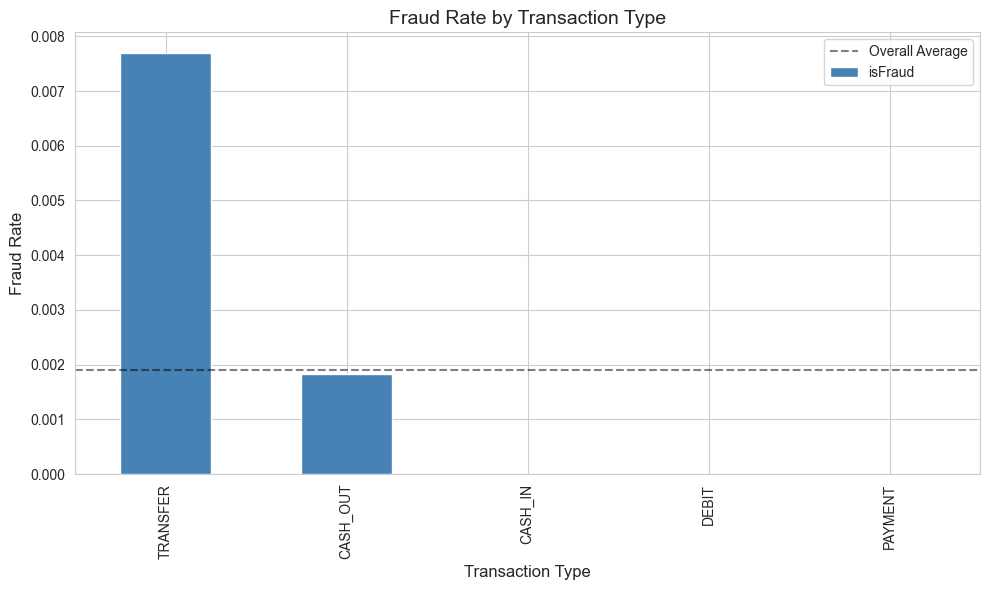

In [6]:
# EDA
print("EXPLORATORY DATA ANALYSIS \n ")


# fraud distribution
print("\n Fraud Distribution:")
fraud_counts = data_clean['isFraud'].value_counts()
fraud_percentage = data_clean['isFraud'].value_counts(normalize=True) * 100

for i, (count, perc) in enumerate(zip(fraud_counts, fraud_percentage)):
    label = "Fraud" if i == 1 else "Not Fraud"
    print(f"  {label}: {count:,} ({perc:.2f}%)")

# transaction types
print("\n Transaction Types Distribution:")
print(data_clean['type'].value_counts())

# fraud rate by transaction type
print("\n Fraud Rate by Transaction Type:")
fraud_by_type = data_clean.groupby('type')['isFraud'].mean().sort_values(ascending=False)
for trans_type, rate in fraud_by_type.items():
    print(f"  {trans_type}: {rate:.4f} ({rate*100:.2f}%)")

# visualize fraud by type
plt.figure(figsize=(10, 6))
fraud_by_type.plot(kind='bar', color=['red' if x > 0.1 else 'steelblue' for x in fraud_by_type])
plt.title('Fraud Rate by Transaction Type', fontsize=14)
plt.xlabel('Transaction Type', fontsize=12)
plt.ylabel('Fraud Rate', fontsize=12)
plt.axhline(y=fraud_by_type.mean(), color='black', linestyle='--', alpha=0.5, label='Overall Average')
plt.legend()
plt.tight_layout()
plt.show()

In [7]:
# feature Engineering
def create_features(data):
    print("FEATURE ENGINEERING : \n")
    
    df = data.copy()
    
    # balance mismatch features
    df["orig_mismatch_flag"] = (~np.isclose(
        df["newbalanceOrig"], 
        df["oldbalanceOrg"] - df["amount"], 
        atol=TOL
    )).astype(int)
    
    df["dest_mismatch_flag"] = (~np.isclose(
        df["newbalanceDest"], 
        df["oldbalanceDest"] + df["amount"], 
        atol=TOL
    )).astype(int)
    
    # account type features
    df["name_org_type"] = df["nameOrig"].str[0]
    df["name_dest_type"] = df["nameDest"].str[0]
    
    # time related features (sorted by step)
    df.sort_values("step", inplace=True)
    
    # destination features (cumulative counts)
    df["dest_count_so_far"] = df.groupby("nameDest").cumcount()
    df["dest_seen_before"] = (df["dest_count_so_far"] > 0).astype(int)
    
    # sender features
    df["origin_txn_count"] = df.groupby("nameOrig").cumcount()
    
    # suspicious pattern flags
    df["suspicious_dest_balance"] = (
        (df["newbalanceDest"] == 0) & 
        (df["amount"] > 0) & 
        (df["type"].isin(["TRANSFER", "CASH_OUT"]))
    ).astype(int)
    
    df["high_amount_flag"] = (df["amount"] > HIGH_AMOUNT_THRESHOLD).astype(int)
    
    df["sus_sender"] = (
        (df["high_amount_flag"] == 1) & 
        (df["origin_txn_count"] < SUSPICIOUS_SENDER_MIN_TXNS)
    ).astype(int)
    
    df["is_first_time_dest"] = (df["dest_seen_before"] == 0).astype(int)
    df["sus_sender_dest"] = ((df["is_first_time_dest"] == 1) & (df["sus_sender"] == 1)).astype(int)
    
    # ratio features
    df["amount_to_orig_balance_ratio"] = (
        df["amount"] / (df["oldbalanceOrg"].replace(0, np.nan) + 1)
    ).fillna(0)
    
    df["amount_to_dest_balance_ratio"] = (
        df["amount"] / (df["oldbalanceDest"].replace(0, np.nan) + 1)
    ).fillna(0)
    
    # interaction feature
    df["txn_risk_signal"] = (
        df["amount_to_dest_balance_ratio"] * 
        (df["sus_sender_dest"] + 1) * 
        (df["dest_seen_before"] + 1)
    )
    
    print(f" Created {len(df.columns) - len(data.columns)} new features")
    print(f" Total features: {len(df.columns)}")
    
    return df

data_with_features = create_features(data_clean)
print("\n New features created:")
print([col for col in data_with_features.columns if col not in data_clean.columns])

FEATURE ENGINEERING : 

 Created 15 new features
 Total features: 26

 New features created:
['orig_mismatch_flag', 'dest_mismatch_flag', 'name_org_type', 'name_dest_type', 'dest_count_so_far', 'dest_seen_before', 'origin_txn_count', 'suspicious_dest_balance', 'high_amount_flag', 'sus_sender', 'is_first_time_dest', 'sus_sender_dest', 'amount_to_orig_balance_ratio', 'amount_to_dest_balance_ratio', 'txn_risk_signal']


In [9]:
numeric_col=data_with_features.select_dtypes(include="number").columns.drop("isFraud")
corr_with_target = data_with_features[numeric_col].corrwith(data_with_features["isFraud"]).abs()
corr_with_target = corr_with_target.sort_values(ascending=False)
corr_with_target

suspicious_dest_balance         0.348902
sus_sender_dest                 0.146399
sus_sender                      0.078358
high_amount_flag                0.078358
amount                          0.076724
orig_mismatch_flag              0.068421
isFlaggedFraud                  0.044125
step                            0.031539
dest_seen_before                0.014670
is_first_time_dest              0.014670
dest_count_so_far               0.010961
oldbalanceOrg                   0.010166
newbalanceOrig                  0.008143
dest_mismatch_flag              0.006227
oldbalanceDest                  0.005879
amount_to_dest_balance_ratio    0.001586
txn_risk_signal                 0.001460
amount_to_orig_balance_ratio    0.001229
origin_txn_count                0.000682
newbalanceDest                  0.000544
dtype: float64

In [11]:
#

# features with correlation >= 0.05
high_corr_features = [
    'suspicious_dest_balance', 
    'amount_to_dest_balance_ratio', 
    'txn_risk_signal',  
    'sus_sender',
    'sus_sender_dest',  
    'amount',  
    'orig_mismatch_flag', 
    'isFlaggedFraud',
    'step', 
    'type' 
]

print(f"✅ Selected {len(high_corr_features)} features:")
for i, feat in enumerate(high_corr_features, 1):
    print(f"{i:2d}. {feat}")

# Verify all selected features exist
missing = [f for f in high_corr_features if f not in data_with_features.columns]
if missing:
    print(f"\n Missing features: {missing}")
else:
    print(f"\n All selected features are available")

✅ Selected 10 features:
 1. suspicious_dest_balance
 2. amount_to_dest_balance_ratio
 3. txn_risk_signal
 4. sus_sender
 5. sus_sender_dest
 6. amount
 7. orig_mismatch_flag
 8. isFlaggedFraud
 9. step
10. type

 All selected features are available


In [14]:
# Cell 7: Time-based Data Splitting
def split_data_by_time(data, time_col='step', test_size=TEST_SIZE):

    print("TIME-BASED DATA SPLITTING : \n ")
   
    
    # sort by time
    data = data.sort_values(time_col)
    
    split_step = int(data[time_col].max() * (1 - test_size))
    
    train_data = data[data[time_col] <= split_step].copy()
    test_data = data[data[time_col] > split_step].copy()
    
    print(f" Time range: {data[time_col].min()} to {data[time_col].max()}")
    print(f" Split point (step): {split_step}")
    print(f" Train size: {len(train_data):,} ({len(train_data)/len(data)*100:.1f}%)")
    print(f" Test size:  {len(test_data):,} ({len(test_data)/len(data)*100:.1f}%)")
    
    train_fraud_rate = train_data['isFraud'].mean() * 100
    test_fraud_rate = test_data['isFraud'].mean() * 100
    
    print(f"\n Fraud rates:")
    print(f"  Train: {train_fraud_rate:.3f}%")
    print(f"  Test:  {test_fraud_rate:.3f}%")
    
    return train_data, test_data

# select the features we need (high corr ones)
selected_data = data_with_features[high_corr_features + ['isFraud']].copy()

train_data, test_data = split_data_by_time(selected_data)

TIME-BASED DATA SPLITTING : 
 
 Time range: 1 to 743
 Split point (step): 594
 Train size: 6,239,038 (98.1%)
 Test size:  123,576 (1.9%)

 Fraud rates:
  Train: 0.105%
  Test:  1.335%


In [15]:

print("PREPARING FEATURES : \n ")

# separate categorical and numeric features
categorical_features = train_data.select_dtypes(include=['object']).columns.tolist()
numeric_features = [f for f in high_corr_features if f not in categorical_features]

# removing target if it is in the list
if 'isFraud' in numeric_features:
    numeric_features.remove('isFraud')

print(f" Feature breakdown:")
print(f"  Numeric features:    {len(numeric_features)}")
for feat in numeric_features:
    print(f"    - {feat}")
print(f"  Categorical features: {len(categorical_features)}")
for feat in categorical_features:
    print(f"    - {feat}")

# Prepare X and y
train_X = train_data[numeric_features + categorical_features]
train_y = train_data['isFraud']
test_X = test_data[numeric_features + categorical_features]
test_y = test_data['isFraud']

print(f"\n Train X shape: {train_X.shape}")
print(f" Train y shape: {train_y.shape}")
print(f" Test X shape:  {test_X.shape}")
print(f" Test y shape:  {test_y.shape}")

PREPARING FEATURES : 
 
 Feature breakdown:
  Numeric features:    9
    - suspicious_dest_balance
    - amount_to_dest_balance_ratio
    - txn_risk_signal
    - sus_sender
    - sus_sender_dest
    - amount
    - orig_mismatch_flag
    - isFlaggedFraud
    - step
  Categorical features: 1
    - type

 Train X shape: (6239038, 10)
 Train y shape: (6239038,)
 Test X shape:  (123576, 10)
 Test y shape:  (123576,)


In [16]:
def create_model_pipelines(categorical_features, numeric_features, train_y):
    print("CREATING MODEL PIPELINES")
    
    # calculate class weights
    fraud_count = train_y.sum()
    non_fraud_count = len(train_y) - fraud_count
    scale_pos_weight = non_fraud_count / max(fraud_count, 1)
    
    print(f" Class distribution:")
    print(f"  Non-fraud: {non_fraud_count:,}")
    print(f"  Fraud:     {fraud_count:,}")
    print(f"  Ratio (non-fraud:fraud): {scale_pos_weight:.2f}:1")
    
    # preprocessors
    preprocessor_lr = ColumnTransformer([
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_features)
    ])
    
    preprocessor_trees = ColumnTransformer([
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_features)
    ], remainder='passthrough')
    
    # logistic Regression
    lr_pipeline = Pipeline([
        ("preprocessor", preprocessor_lr),
        ("clf", LogisticRegression(
            class_weight="balanced",
            max_iter=1000,
            random_state=RANDOM_STATE,
            solver='lbfgs'
        ))
    ])
    
    # random Forest
    rf_pipeline = Pipeline([
        ('preprocessor', preprocessor_trees),
        ('clf', RandomForestClassifier(
            n_estimators=200,
            class_weight='balanced',
            n_jobs=-1,
            random_state=RANDOM_STATE,
            max_depth=10,
            min_samples_split=10
        ))
    ])
    
    # XGBoost
    xgb_pipeline = Pipeline([
        ('preprocessor', preprocessor_trees),
        ('clf', XGBClassifier(
            n_estimators=200,
            scale_pos_weight=scale_pos_weight,
            learning_rate=0.1,
            max_depth=6,
            subsample=0.8,
            colsample_bytree=0.8,
            use_label_encoder=False,
            eval_metric='logloss',
            n_jobs=-1,
            random_state=RANDOM_STATE,
            verbosity=0
        ))
    ])
    
    # catBoost
    cat_pipeline = Pipeline([
        ('preprocessor', preprocessor_trees),
        ('clf', CatBoostClassifier(
            iterations=500,
            learning_rate=0.05,
            depth=6,
            loss_function='Logloss',
            eval_metric='PRAUC',
            verbose=0,
            random_seed=RANDOM_STATE,
            class_weights=[1, scale_pos_weight]
        ))
    ])
    
    models = {
        "Logistic Regression": lr_pipeline,
        "Random Forest": rf_pipeline,
        "XGBoost": xgb_pipeline,
        "CatBoost": cat_pipeline
    }
    
    print(f"\n Created {len(models)} model pipelines")
    
    return models, scale_pos_weight

models, scale_pos_weight = create_model_pipelines(categorical_features, numeric_features, train_y)

CREATING MODEL PIPELINES
 Class distribution:
  Non-fraud: 6,232,481
  Fraud:     6,557
  Ratio (non-fraud:fraud): 950.51:1

 Created 4 model pipelines


In [17]:
def evaluate_model(pipeline, train_X, train_y, test_X, test_y, model_name="Model"):
    print(f"EVALUATING {model_name.upper()}")
    
    # training model
    start_time = datetime.now()
    pipeline.fit(train_X, train_y)
    training_time = (datetime.now() - start_time).total_seconds()
    
    # predict probabilities
    pred_probs = pipeline.predict_proba(test_X)[:, 1]
    
    # find the best threshold
    precision, recall, thresholds = precision_recall_curve(test_y, pred_probs)
    f1_scores = 2 * precision * recall / (precision + recall + 1e-10)
    
    # get threshold that maximizes F1
    best_f1_idx = np.argmax(f1_scores[:-1])
    best_thr = thresholds[best_f1_idx]
    best_f1 = f1_scores[best_f1_idx]
    
    # predict with best threshold
    pred_labels = (pred_probs >= best_thr).astype(int)
    
    # calculate metrics
    pr_auc = average_precision_score(test_y, pred_probs)
    roc_auc = roc_auc_score(test_y, pred_probs)
    
    # confusion matrix
    cm = confusion_matrix(test_y, pred_labels)
    tn, fp, fn, tp = cm.ravel()
    
    # business metrics
    fraud_amounts = test_X['amount'].values if 'amount' in test_X.columns else np.full(len(test_y), FRAUD_AVERAGE_LOSS)
    caught_fraud_amount = fraud_amounts[(test_y == 1) & (pred_labels == 1)].sum()
    missed_fraud_amount = fraud_amounts[(test_y == 1) & (pred_labels == 0)].sum()
    false_alarm_cost = fp * COST_PER_INVESTIGATION
    net_savings = caught_fraud_amount - false_alarm_cost
    
    #  results
    print(f" Optimal Threshold: {best_thr:.4f} (F1={best_f1:.4f})")
    
    print(f"\n Performance Metrics:")
    print(f"  PR-AUC:        {pr_auc:.4f}")
    print(f"  ROC-AUC:       {roc_auc:.4f}")
    print(f"  F1 Score:      {f1_score(test_y, pred_labels):.4f}")
    print(f"  Precision:     {precision_score(test_y, pred_labels):.4f}")
    print(f"  Recall:        {recall_score(test_y, pred_labels):.4f}")
    
    print(f"\n Confusion Matrix:")
    print(f"  True Negatives:  {tn:>6}")
    print(f"  False Positives: {fp:>6}")
    print(f"  False Negatives: {fn:>6}")
    print(f"  True Positives:  {tp:>6}")
    
    print(f"\n Business Impact:")
    print(f"  Fraud caught:    ${caught_fraud_amount:,.2f}")
    print(f"  Fraud missed:    ${missed_fraud_amount:,.2f}")
    print(f"  Investigation cost: ${false_alarm_cost:,.2f}")
    print(f"  Net savings:     ${net_savings:,.2f}")
    
    print(f"\n⏱ Training time: {training_time:.2f} seconds")
    
    return {
        "model_name": model_name,
        "best_threshold": best_thr,
        "pr_auc": pr_auc,
        "roc_auc": roc_auc,
        "f1": f1_score(test_y, pred_labels),
        "precision": precision_score(test_y, pred_labels),
        "recall": recall_score(test_y, pred_labels),
        "training_time": training_time,
        "confusion_matrix": cm,
        "pred_probs": pred_probs,
        "pred_labels": pred_labels,
        "business_metrics": {
            "caught_fraud_amount": caught_fraud_amount,
            "missed_fraud_amount": missed_fraud_amount,
            "false_alarm_cost": false_alarm_cost,
            "net_savings": net_savings
        }
    }

In [ ]:
# baseline Model Evaluation (before SMOTE)
baseline_results = []
for name, pipeline in models.items():
    result = evaluate_model(pipeline, train_X, train_y, test_X, test_y, name)
    baseline_results.append(result)

# create results DataFrame
results_df = pd.DataFrame([{
    'model_name': r['model_name'],
    'pr_auc': r['pr_auc'],
    'roc_auc': r['roc_auc'],
    'f1': r['f1'],
    'precision': r['precision'],
    'recall': r['recall'],
    'training_time': r['training_time'],
    'best_threshold': r['best_threshold']
} for r in baseline_results])

print("\n Summary of Baseline Models:")
display(results_df.sort_values('pr_auc', ascending=False))


BASELINE MODEL EVALUATION (NO SMOTE)
EVALUATING LOGISTIC REGRESSION
 Optimal Threshold: 0.9339 (F1=0.8489)

 Performance Metrics:
  PR-AUC:        0.8815
  ROC-AUC:       0.9960
  F1 Score:      0.8489
  Precision:     0.9518
  Recall:        0.7661

 Confusion Matrix:
  True Negatives:  121862
  False Positives:     64
  False Negatives:    386
  True Positives:    1264

 Business Impact:
  Fraud caught:    $2,660,055,545.54
  Fraud missed:    $62,379,023.82
  Investigation cost: $3,200.00
  Net savings:     $2,660,052,345.54

⏱ Training time: 61.72 seconds
EVALUATING RANDOM FOREST
 Optimal Threshold: 0.8423 (F1=0.8158)

 Performance Metrics:
  PR-AUC:        0.8737
  ROC-AUC:       0.9958
  F1 Score:      0.8158
  Precision:     0.9017
  Recall:        0.7448

 Confusion Matrix:
  True Negatives:  121792
  False Positives:    134
  False Negatives:    421
  True Positives:    1229

 Business Impact:
  Fraud caught:    $2,641,153,623.77
  Fraud missed:    $81,280,945.59
  Investigati

,model_name,pr_auc,roc_auc,f1,precision,recall,training_time,best_threshold
3,CatBoost,0.894358,0.996345,0.856285,0.951816,0.778182,1190.892224,0.989870
2,XGBoost,0.893226,0.996413,0.855145,0.949002,0.778182,139.602978,0.974813
0,Logistic Regression,0.881455,0.996007,0.848892,0.951807,0.766061,61.724974,0.933921
1,Random Forest,0.873727,0.995848,0.815798,0.901687,0.744848,1366.890903,0.842339


In [20]:
#  SMOTE for the  Tree Models

cat_indices = [train_X.columns.get_loc(col) for col in categorical_features]

smote_results = []
# selecting the tree models
tree_models = {
    "Random Forest (SMOTE)": models["Random Forest"],
    "XGBoost (SMOTE)": models["XGBoost"],
    "CatBoost (SMOTE)": models["CatBoost"]
}

for name, pipeline in tree_models.items():

    # applying SMOTE
    smote_nc = SMOTENC(categorical_features=cat_indices, random_state=RANDOM_STATE)
    train_X_res, train_y_res = smote_nc.fit_resample(train_X, train_y)
    
    print(f"\n After SMOTE for {name}:")
    print(f"  Original train size: {len(train_X):,}")
    print(f"  Resampled train size: {len(train_X_res):,}")
    print(f"  Fraud class ratio: 1:{len(train_y_res[train_y_res==0])/len(train_y_res[train_y_res==1]):.1f}")
    
    # evaluate with SMOTE
    result = evaluate_model(pipeline, train_X_res, train_y_res, test_X, test_y, name)
    smote_results.append(result)

# combine all results
all_results = baseline_results + smote_results
all_results_df = pd.DataFrame([{
    'model_name': r['model_name'],
    'pr_auc': r['pr_auc'],
    'roc_auc': r['roc_auc'],
    'f1': r['f1'],
    'precision': r['precision'],
    'recall': r['recall'],
    'training_time': r['training_time'],
    'best_threshold': r['best_threshold']
} for r in all_results])

print("\n Summary of All Models:")
display(all_results_df.sort_values('pr_auc', ascending=False))


 After SMOTE for Random Forest (SMOTE):
  Original train size: 6,239,038
  Resampled train size: 12,464,962
  Fraud class ratio: 1:1.0
EVALUATING RANDOM FOREST (SMOTE)


KeyboardInterrupt: 

In [ ]:

print("MODEL COMPARISON VISUALIZATION : \n ")


fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# PR-AUC comparison
sorted_df = all_results_df.sort_values('pr_auc')
axes[0,0].barh(range(len(sorted_df)), sorted_df['pr_auc'], color='steelblue')
axes[0,0].set_yticks(range(len(sorted_df)))
axes[0,0].set_yticklabels(sorted_df['model_name'])
axes[0,0].set_xlabel('PR-AUC Score')
axes[0,0].set_title('PR-AUC Comparison')
axes[0,0].axvline(x=sorted_df['pr_auc'].max(), color='red', linestyle='--', alpha=0.7)

# F1 Score comparison
axes[0,1].barh(range(len(sorted_df)), sorted_df['f1'], color='forestgreen')
axes[0,1].set_yticks(range(len(sorted_df)))
axes[0,1].set_yticklabels(sorted_df['model_name'])
axes[0,1].set_xlabel('F1 Score')
axes[0,1].set_title('F1 Score Comparison')
axes[0,1].axvline(x=sorted_df['f1'].max(), color='red', linestyle='--', alpha=0.7)

#  Recall comparison
axes[0,2].barh(range(len(sorted_df)), sorted_df['recall'], color='darkorange')
axes[0,2].set_yticks(range(len(sorted_df)))
axes[0,2].set_yticklabels(sorted_df['model_name'])
axes[0,2].set_xlabel('Recall')
axes[0,2].set_title('Recall Comparison')
axes[0,2].axvline(x=sorted_df['recall'].max(), color='red', linestyle='--', alpha=0.7)


# Precision-Recall tradeoff
for idx, row in sorted_df.iterrows():
    axes[1,1].scatter(row['recall'], row['precision'], s=200, 
                     label=row['model_name'], alpha=0.7)

axes[1,1].set_xlabel('Recall')
axes[1,1].set_ylabel('Precision')
axes[1,1].set_title('Precision-Recall Tradeoff')
axes[1,1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1,1].grid(True, alpha=0.3)

# ROC-AUC comparison
axes[1,2].barh(range(len(sorted_df)), sorted_df['roc_auc'], color='purple')
axes[1,2].set_yticks(range(len(sorted_df)))
axes[1,2].set_yticklabels(sorted_df['model_name'])
axes[1,2].set_xlabel('ROC-AUC Score')
axes[1,2].set_title('ROC-AUC Comparison')
axes[1,2].axvline(x=sorted_df['roc_auc'].max(), color='red', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [ ]:

print("PRECISION-RECALL CURVES: \n")

plt.figure(figsize=(10, 8))

for result in all_results:
    precision, recall, _ = precision_recall_curve(test_y, result['pred_probs'])
    plt.plot(recall, precision, label=f"{result['model_name']} (AP={result['pr_auc']:.4f})", 
            linewidth=2)

plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curves Comparison', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.xlim([0, 1])
plt.ylim([0, 1])

plt.axhline(y=test_y.mean(), color='black', linestyle='--', alpha=0.5, label=f'No Skill (AP={test_y.mean():.3f})')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
print("FEATURE IMPORTANCE ANALYSIS : \n")

# find best model
best_model_row = all_results_df.loc[all_results_df['pr_auc'].idxmax()]
best_model_name = best_model_row['model_name']
print(f" Best Model: {best_model_name} (PR-AUC: {best_model_row['pr_auc']:.4f})")

# model name withought SMOTE
original_model_name = best_model_name.replace(" (SMOTE)", "")
best_model_pipeline = models[original_model_name]

# Get feature names after preprocessing
preprocessor = best_model_pipeline.named_steps['preprocessor']
preprocessor.fit(train_X)

if hasattr(preprocessor, 'get_feature_names_out'):
    feature_names = preprocessor.get_feature_names_out()
    
    # Get the model
    model = best_model_pipeline.named_steps['clf']
    
    # Check if model has feature importance
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        
        # Create DataFrame
        feat_imp_df = pd.DataFrame({
            'feature': feature_names[:len(importances)],
            'importance': importances
        }).sort_values('importance', ascending=False).head(15)
        
        # Plot
        plt.figure(figsize=(10, 8))
        plt.barh(feat_imp_df['feature'], feat_imp_df['importance'], color='steelblue')
        plt.xlabel('Feature Importance', fontsize=12)
        plt.title(f'{best_model_name} - Top 15 Feature Importances', fontsize=14)
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()
        
        print("\n📊 Top 10 features:")
        for i, (feat, imp) in enumerate(feat_imp_df.head(10).values, 1):
            print(f"  {i:2d}. {feat:40s}: {imp:.4f}")

In [ ]:

# Find best overall model
best_overall = all_results_df.loc[all_results_df['pr_auc'].idxmax()]
second_best = all_results_df.loc[all_results_df['pr_auc'].nlargest(2).index[1]]

print(f"\n BEST OVERALL MODEL: {best_overall['model_name']}")
print(f"   PR-AUC: {best_overall['pr_auc']:.4f}")
print(f"   F1 Score: {best_overall['f1']:.4f}")
print(f"   Recall: {best_overall['recall']:.4f}")
print(f"   Optimal Threshold: {best_overall['best_threshold']:.4f}")

print(f"\n Second Best Model: {second_best['model_name']}")
print(f"   PR-AUC: {second_best['pr_auc']:.4f}")


print("\n📈 BUSINESS IMPACT:")
for result in all_results:
    if result['model_name'] == best_overall['model_name']:
        bm = result['business_metrics']
        print(f"  With {best_overall['model_name']}:")
        print(f"  • Fraud caught: ${bm['caught_fraud_amount']:,.2f}")
        print(f"  • Investigation cost: ${bm['false_alarm_cost']:,.2f}")
        print(f"  • Net savings: ${bm['net_savings']:,.2f}")
        break



In [ ]:
# Create results directory
os.makedirs('results', exist_ok=True)

# Save results to CSV
all_results_df.to_csv('results/model_results.csv', index=False)

# Save best model metrics
best_result = next(r for r in all_results if r['model_name'] == best_overall['model_name'])
with open('results/best_model_metrics.json', 'w') as f:
    json.dump({
        'model_name': best_result['model_name'],
        'pr_auc': float(best_result['pr_auc']),
        'f1_score': float(best_result['f1']),
        'recall': float(best_result['recall']),
        'optimal_threshold': float(best_result['best_threshold']),
        'business_impact': best_result['business_metrics']
    }, f, indent=2)

print(" Results saved to 'results/' directory")